# Machine Learning Trading Bot
##### Created by [Demi Oyebanji](mailto:oluwademiladeoyebanji@outlook.com) as an assignment for the **UofT SCS Financial Technology Bootcamp**


In [1]:
#Import Packages
import pandas as pd
from pathlib import Path
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline


## Data Prep

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

C:\Users\Oluwa\AppData\Local\Temp\ipykernel_10420\4032096739.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ohlcv_df = pd.read_csv(
C:\Users\Oluwa\AppData\Local\Temp\ipykernel_10420\4032096739.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ohlcv_df = pd.read_csv(


,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Simple Logic

### Define a 'Short' and 'Long' Window and calculate the moving averages for those periods

In [4]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

### Create a new column that signals whether a Stock should be bought or sold based on if returns are negative or positive

In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [6]:
signals_df['Signal'].value_counts()

Signal
 1.0    2368
-1.0    1855
Name: count, dtype: int64

### Gauge how well the strategy performed by calculating the returns based on if the Signal said to sell or buy in the previous row

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.9325,24.3411,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.9475,24.3463,1.0,0.001202


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<Axes: xlabel='date'>

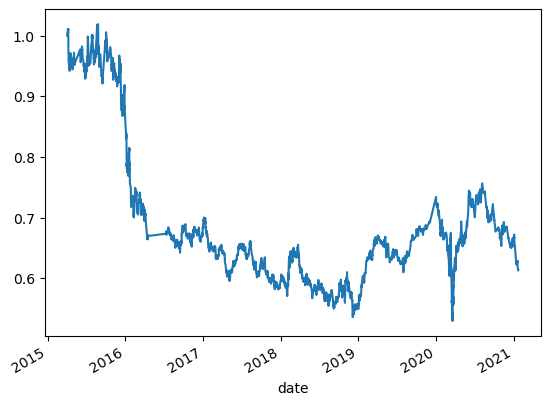

In [8]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

## Machine Learning Model

### Prepare The Data To Be Analyzed Using Machine Learning

In [9]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [10]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    2368
-1.0    1855
Name: count, dtype: int64

In [11]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [12]:
# Select the ending period for the training data with an offset of 12 months
training_end = X.index.min() + DateOffset(months=12)

# Display the training end date
print(training_end)

2016-04-02 15:00:00


In [13]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360
2015-04-02 15:45:00,24.9325,24.3411
2015-04-06 09:30:00,24.9475,24.3463


In [14]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=24):]
y_test = y.loc[training_end+DateOffset(hours=24):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2016-04-04 11:30:00,20.61250,20.10780
2016-04-04 13:00:00,20.56500,20.12270
2016-04-06 12:15:00,20.54975,20.13799
2016-04-13 15:00:00,20.44475,20.14899
2016-04-13 15:45:00,20.64475,20.16849


In [15]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Use the `SVC` classifier model to make predictions

In [16]:
# From SVM, instantiate SVC classifier model instance
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', C=15, random_state=100)
 
# Fit the model to the data using the training data
svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test)

# Review the model's predicted values
print("SVM Predictions:", svm_pred)


SVM Predictions: [1. 1. 1. ... 1. 1. 1.]


F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


### Review the classification report for these predictions

In [17]:
from sklearn.metrics import classification_report
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print("Classification Report for SVM Model:")
print(svm_testing_report)

Classification Report for SVM Model:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      1497
         1.0       0.56      1.00      0.72      1931

    accuracy                           0.56      3428
   macro avg       0.28      0.50      0.36      3428
weighted avg       0.32      0.56      0.41      3428



F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Compare “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [18]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame()
predictions_df.index = X_test.index

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2016-04-04 11:30:00,1.0,0.012802,-0.012802
2016-04-04 13:00:00,1.0,0.003354,0.003354
2016-04-06 12:15:00,1.0,-0.018363,-0.018363
2016-04-13 15:00:00,1.0,0.041955,-0.041955
2016-04-13 15:45:00,1.0,-0.000474,-0.000474


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,-0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Plot the cumulative return

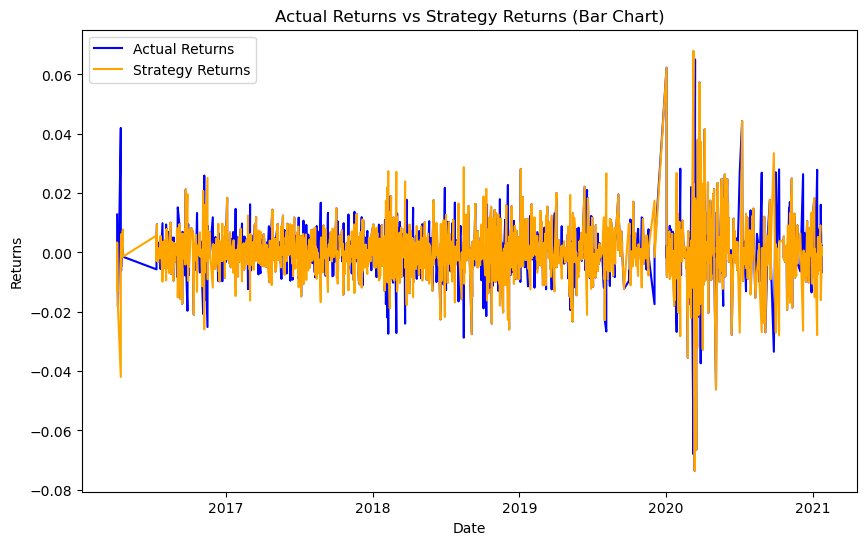

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the actual returns versus the strategy returns
plt.figure(figsize=(10, 6))
plt.plot(predictions_df.index, predictions_df['Actual Returns'], label='Actual Returns', color='blue')

# Plot strategy returns with a slight shift to the right
plt.plot(predictions_df.index, predictions_df['Strategy Returns'], label='Strategy Returns', color='orange')

# Customize the plot
plt.title('Actual Returns vs Strategy Returns (Bar Chart)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
plt.savefig('best plot')


### Use The ADABoost Classifier to make predictions

In [20]:
# Import a new classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)


In [21]:
# Fit the model using the training data
model = adaboost_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test)

# Review the model's predicted values
print("ADA Predictions:", pred)


ADA Predictions: [-1. -1. -1. ... -1. -1. -1.]


F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


### Evaluate the performance of the new model

In [22]:
# Use a classification report to evaluate the model using the predictions and testing data
ada_testing_report = classification_report(y_test, pred)

# Print the classification report
print("Classification Report for ADA Model:")
print(ada_testing_report)




Classification Report for ADA Model:
              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61      1497
         1.0       0.00      0.00      0.00      1931

    accuracy                           0.44      3428
   macro avg       0.22      0.50      0.30      3428
weighted avg       0.19      0.44      0.27      3428



F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\DemiDev\Applications\AnacondaInstall\envs\DemiDev\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

## Findings

### Compare “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [25]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
ADA_predictions = pd.DataFrame()
ADA_predictions.index = X_test.index

# Add the SVM model predictions to the DataFrame
ADA_predictions['Predictions'] = pred
# Add the actual returns to the DataFrame
ADA_predictions['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
ADA_predictions['Strategy Returns'] = signals_df['Strategy Returns']

# Review the DataFrame
display(ADA_predictions)


,Predictions,Actual Returns,Strategy Returns
date,,,
2016-04-04 11:30:00,-1.0,0.012802,-0.012802
2016-04-04 13:00:00,-1.0,0.003354,0.003354
2016-04-06 12:15:00,-1.0,-0.018363,-0.018363
2016-04-13 15:00:00,-1.0,0.041955,-0.041955
2016-04-13 15:45:00,-1.0,-0.000474,-0.000474
...,...,...,...
2021-01-22 09:30:00,-1.0,-0.006866,-0.006866
2021-01-22 11:30:00,-1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,0.002099,0.002099


### Plot Strategy Returns and Actual Returns on a Bar Chart

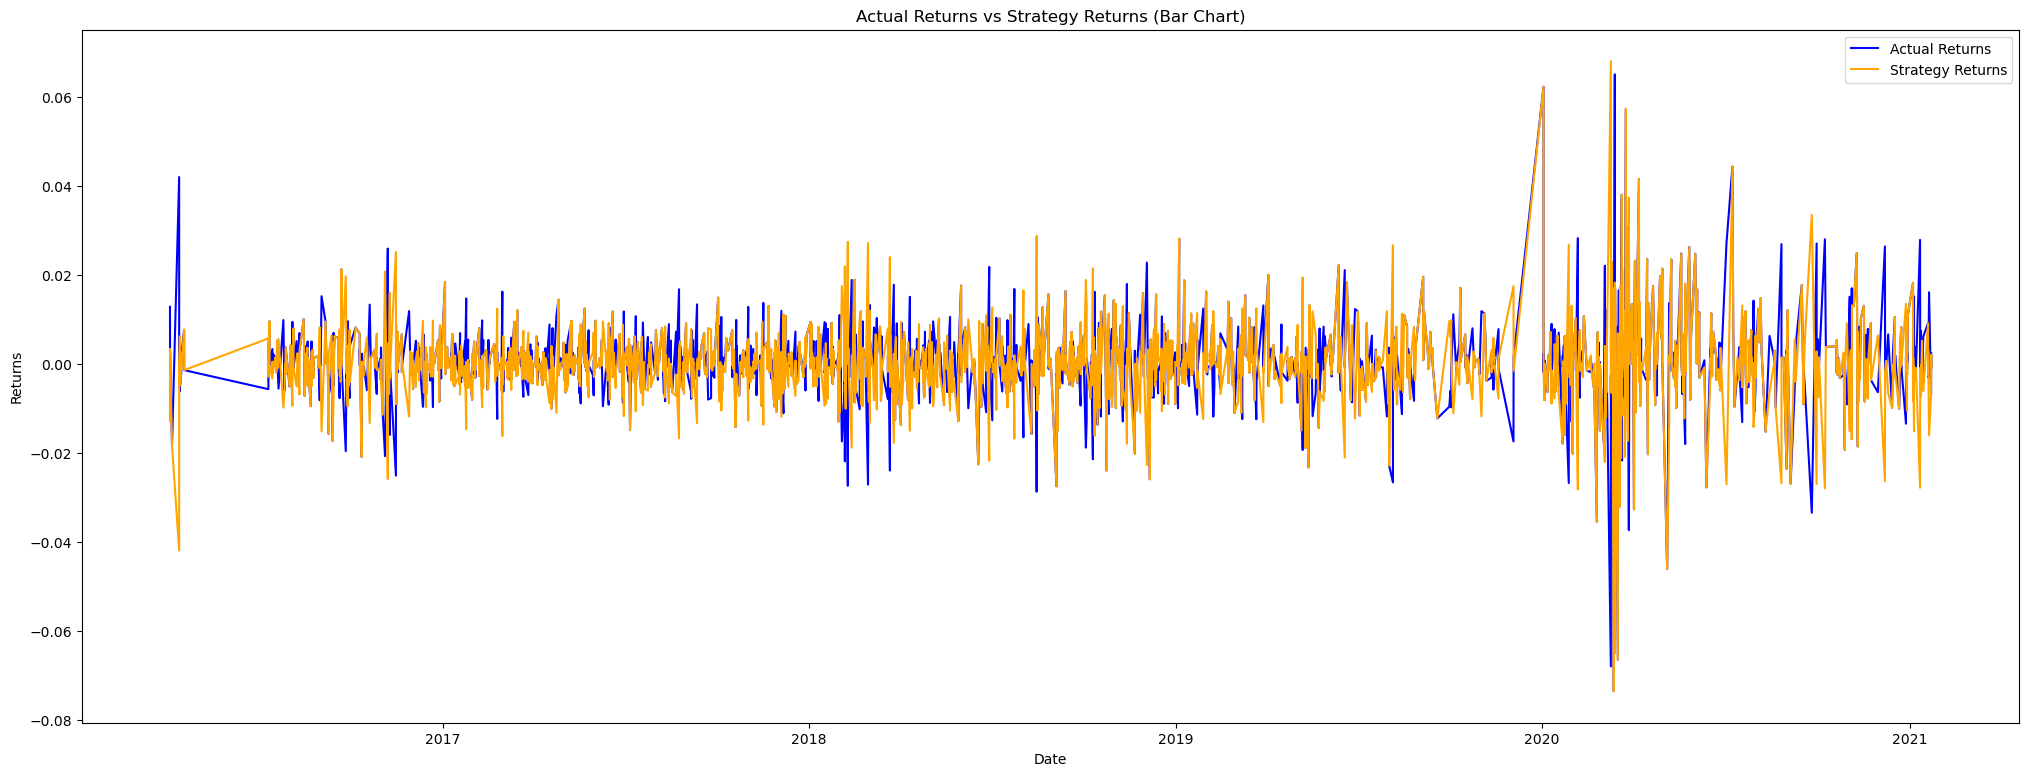

<Figure size 640x480 with 0 Axes>

In [28]:
# Plot the actual returns versus the strategy returns
plt.figure(figsize=(25, 9))
plt.plot(predictions_df.index, ADA_predictions['Actual Returns'], label='Actual Returns', color='blue')

# Plot strategy returns with a slight shift to the right
plt.plot(predictions_df.index, ADA_predictions['Strategy Returns'], label='Strategy Returns', color='orange')

# Customize the plot
plt.title('Actual Returns vs Strategy Returns (Bar Chart)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
plt.savefig('ADA plot')